# Main Wildfire Visualizations

This notebook performs the end-to-end workflow for the wildfire simulation project:

- Download Hansen Global Forest Change rasters for a single 10°×10° tile.
- Crop + downsample the rasters into a tractable simulation grid.
- Construct a simple annual fuel-density time series (2000–2019) from `treecover2000`, `lossyear`, `gain`, and `datamask`.
- Run Monte Carlo wildfire simulations per year under two scenarios:
  - **Baseline** (no mitigation)
  - **Thinning** (uniform fuel reduction)
- Visualize results (risk maps and time-series summaries).
- Quantify thinning effectiveness with confidence intervals and a permutation-test p-value with a Holm–Bonferroni correction across years.

Notes:
- The selected tile is **60N_120W** (wilderness of northern Canada).
- Many cells below can take time to run (especially Monte Carlo loops); keep `n_runs` modest while iterating.

In [ ]:
# This cell makes the notebook runnable even when weupload it by itself:
# - Clones the GitHub repo if it is not already present in the current working directory.
# - Changes into the repo directory so relative paths (e.g., `data/...`) work.
# - Adds the repo root to `sys.path` so `import simulation` works.

import os
import sys
import subprocess
from pathlib import Path

REPO_URL = "https://github.com/marilevay/wildfire-simulation.git"
REPO_DIRNAME = "wildfire-simulation"

cwd = Path().resolve()
repo_dir = cwd / REPO_DIRNAME

# If the notebook is run *inside* the repo already, keep that.
if (cwd / "simulation").exists():
    repo_dir = cwd

if not repo_dir.exists():
    print(f"Cloning repo into {repo_dir} ...")
    subprocess.check_call(["git", "clone", REPO_URL, str(repo_dir)])

os.chdir(repo_dir)

# Ensure imports resolve from the cloned repo.
if str(repo_dir) not in sys.path:
    sys.path.insert(0, str(repo_dir))

print("Repo ready at:", repo_dir)

Repo ready at: /Users/marina.levay/Documents/GitHub/wildfire-simulation


# Imports

These imports cover:
- **Data acquisition**: `requests`, `PIL.Image`, `Path`
- **Computation**: `numpy`
- **Plotting**: `matplotlib`
- **Progress bars**: `tqdm` for long-running loops

Keeping imports near the top makes the notebook easier to rerun from a fresh kernel.

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
import io
from pathlib import Path
from tqdm.auto import tqdm

## Sanity checks

These checks are a lightweight replacement for the separate `tests.ipynb` notebook.

**Goal:** catch breaking changes in the `simulation/` package before running the slower visualization/Monte Carlo sections.

**What we verify:**
- `Forest` clamps densities into `[0, 1]` and preserves shape.
- `Forest.apply_thinning(factor)` returns a new `Forest`, preserves shape, and never increases density.
- `MonteCarlo.run()` returns burned/affected fractions in `[0, 1]` with `affected ≥ burned`.
- `MonteCarlo.risk_map(n_runs)` returns a grid-shaped probability map in `[0, 1]`.

If these pass, the rest of the notebook should run assuming reasonable parameters.

In [3]:
# Sanity check 1: imports and basic package wiring
#
# Specification:
# - import simulation should succeed after the bootstrap cell.
# - Core symbols should import without side effects.
from simulation import DataCollector, FireModelParams, Forest, MonteCarlo

print("Imported simulation OK")

# Sanity check 2: Forest clamps density to [0, 1] and preserves shape
density = np.array([[1.2, -0.1], [0.4, 0.0]], dtype=float)
forest = Forest(density)

assert forest.density.shape == (2, 2), "Forest should preserve density shape"
assert float(forest.density.max()) <= 1.0, "Forest should clamp density upper bound to 1"
assert float(forest.density.min()) >= 0.0, "Forest should clamp density lower bound to 0"

print("Forest init/clipping OK")

# Sanity check 3: thinning reduces density and preserves shape
thin_factor = 0.5
thin = forest.apply_thinning(thin_factor)

assert thin is not forest, "apply_thinning should return a new Forest"
assert thin.density.shape == forest.density.shape, "Thinned forest should preserve shape"
assert np.all(thin.density <= forest.density + 1e-12), "Thinning should not increase density"

print("Forest thinning OK")

# Sanity check 4: Monte Carlo outputs are well-formed
rng = np.random.default_rng(0)

density3 = np.clip(rng.random((30, 30)) * 0.8, 0.0, 1.0)
forest3 = Forest(density3)

params_check = FireModelParams(
    wind=(1.0, 0.0),
    wind_strength=0.3,
    density_exponent=1.2,
    base_spread=0.7,
)

n_runs_check = 25
mc_check = MonteCarlo(forest=forest3, params=params_check, n_runs=n_runs_check, rng=np.random.default_rng(1))
collector_check = mc_check.run()
burned_check, affected_check = collector_check.convert_to_arrays()

assert burned_check.shape == (n_runs_check,), "burned_fraction should have length n_runs"
assert affected_check.shape == (n_runs_check,), "affected_fraction should have length n_runs"
assert np.all((burned_check >= 0.0) & (burned_check <= 1.0)), "burned fractions must be in [0, 1]"
assert np.all((affected_check >= 0.0) & (affected_check <= 1.0)), "affected fractions must be in [0, 1]"
assert np.all(affected_check + 1e-12 >= burned_check), "affected should be >= burned"

risk_check = mc_check.risk_map(n_runs=n_runs_check)
assert risk_check.shape == forest3.density.shape, "risk_map must match forest grid shape"
assert np.all((risk_check >= 0.0) & (risk_check <= 1.0)), "risk_map values must be in [0, 1]"

mean, lo, hi = DataCollector.calculate_ci95_mean(burned_check)
assert lo <= mean <= hi, "CI bounds must satisfy lo <= mean <= hi"

print("MonteCarlo + risk_map + CI helper OK")

Imported simulation OK
Forest init/clipping OK
Forest thinning OK
MonteCarlo + risk_map + CI helper OK


In [ ]:
# Specify the URL of the data tile

# This project uses the Hansen GFC 2019 v1.7 dataset, which is distributed as 10°×10° GeoTIFF tiles.
# The tile identifier is embedded in the filename (e.g., `60N_120W`).

# wecan swap this URL to analyze a different tile.
url = (
    "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/"
    "Hansen_GFC-2019-v1.7_treecover2000_60N_120W.tif"
)

## Hansen Forest Tile Download

We have to specify the URL of the data tile we want to download.
The important part of the URL is the `00N_010E` part at the end.
This specifies the latitude and longitude (in 10-degree units)
of the data tile to download.

The selected data tile is at `60N_120W`, or the wilderness of northern Canada.

In [5]:
# Load the data. These tiles are large, so we cache to disk and only convert the simulation window
# to a NumPy array (instead of materializing the full 40,000 x 40,000 raster in memory).
Image.MAX_IMAGE_PIXELS = None

def download_if_needed(url: str, out_path: str) -> str:
    p = Path(out_path)
    p.parent.mkdir(parents=True, exist_ok=True)
    if p.exists() and p.stat().st_size > 0:
        return str(p)

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(p, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
    return str(p)


def load_tif_window(path: str, row0: int, col0: int, window_px: int) -> np.ndarray:
    im = Image.open(path)
    box = (int(col0), int(row0), int(col0 + window_px), int(row0 + window_px))
    return np.array(im.crop(box))


treecover_path = download_if_needed(url, "data/treecover2000_tile.tif")

# Use PIL to get raster dimensions without loading the full array.
with Image.open(treecover_path) as _im:
    tile_shape = (_im.height, _im.width)

tile_shape

(40000, 40000)

In [6]:
# Sanity check: tile dimensions (should be 40000x40000)
tile_shape

(40000, 40000)

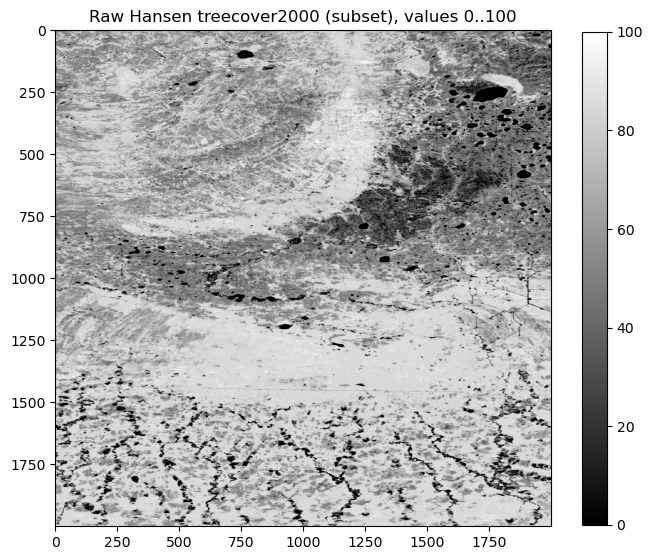

In [7]:
# Plot a small part of the whole data tile (from disk-cached file).
preview = load_tif_window(treecover_path, row0=2000, col0=1000, window_px=2000)

plt.figure(figsize=(8, 8))
plt.imshow(preview, cmap='gray')
plt.colorbar(shrink=0.8)
plt.title("Raw Hansen treecover2000 (subset), values 0..100")
plt.show()

In [ ]:
# Import the simulation package
#
# Specification:
# - The `simulation/` package lives in this repository, so we add the repository root to `sys.path`
#   to make `import simulation` work when running the notebook.

# Note: If weinstall this project as a package instead, wecan remove the sys.path manipulation.

import sys
from pathlib import Path

# Make the project root importable so import simulation works
sys.path.append(str(Path().resolve()))

from simulation import FireModelParams, Forest, MonteCarlo, DataCollector

Loaded preprocessed arrays from data/preprocessed_60N_120W_r2000_c1000_w2000_s200x200.npz


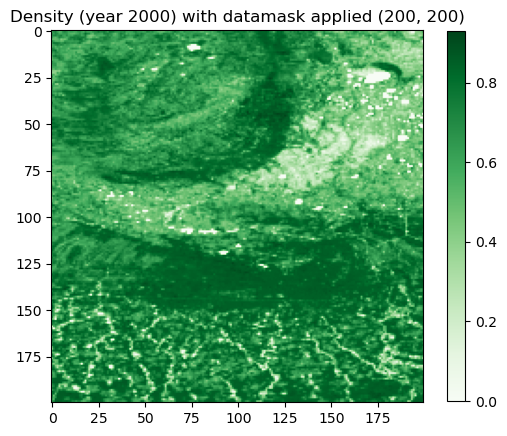

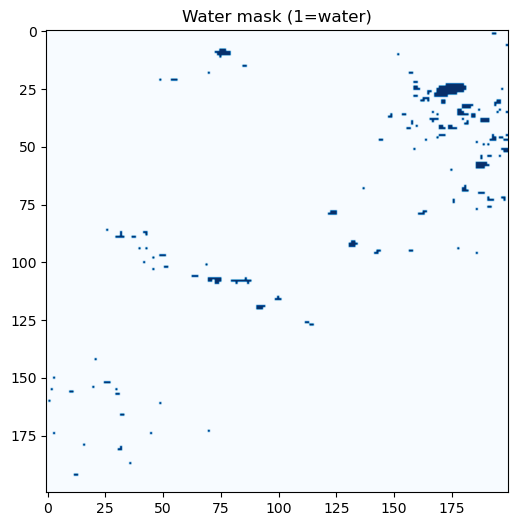

In [9]:
# Preprocessing: crop + downsample Hansen rasters into a simulation-ready grid
#
# To make the notebook runnable in real time (e.g., during a demo), we support a lightweight cache:
# - If a preprocessed `.npz` file exists in `data/`, we load it immediately (fast path).
# - Otherwise we download/crop/downsample the raw GeoTIFFs and then save the `.npz` for reuse.

def mean_pool_2d(a: np.ndarray, out_shape: tuple[int, int]) -> np.ndarray:
    a = np.asarray(a)
    in_rows, in_cols = a.shape
    out_rows, out_cols = out_shape

    if in_rows % out_rows != 0 or in_cols % out_cols != 0:
        raise ValueError("For this simple pooling method, crop so window dims are divisible by out dims")

    r = in_rows // out_rows
    c = in_cols // out_cols
    return a.reshape(out_rows, r, out_cols, c).mean(axis=(1, 3))


# Select a window from the tile and downsample it to a simulation grid.
row0, col0 = 2000, 1000
window_px = 2000
sim_shape = (200, 200)

# Identify the tile and construct a deterministic cache filename.
tile_id = url.split("_treecover2000_")[-1].replace(".tif", "")
preprocessed_path = Path(f"data/preprocessed_{tile_id}_r{row0}_c{col0}_w{window_px}_s{sim_shape[0]}x{sim_shape[1]}.npz")
preprocessed_path.parent.mkdir(parents=True, exist_ok=True)

if preprocessed_path.exists():
    loaded = np.load(preprocessed_path)

    base_density_2000 = loaded["base_density_2000"]
    land_small = loaded["land_small"]
    water_small = loaded["water_small"]
    nodata_small = loaded["nodata_small"]
    lossyear_small = loaded["lossyear_small"]
    gain_small = loaded["gain_small"]

    print(f"Loaded preprocessed arrays from {preprocessed_path}")
else:
    # Derive matching layer URLs from the treecover URL.
    base = "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/"

    datamask_url = base + f"Hansen_GFC-2019-v1.7_datamask_{tile_id}.tif"
    lossyear_url = base + f"Hansen_GFC-2019-v1.7_lossyear_{tile_id}.tif"
    gain_url = base + f"Hansen_GFC-2019-v1.7_gain_{tile_id}.tif"

    datamask_path = download_if_needed(datamask_url, "data/datamask_tile.tif")
    lossyear_path = download_if_needed(lossyear_url, "data/lossyear_tile.tif")
    gain_path = download_if_needed(gain_url, "data/gain_tile.tif")

    # Load raw windows
    window_tree = load_tif_window(treecover_path, row0=row0, col0=col0, window_px=window_px)
    window_mask = load_tif_window(datamask_path, row0=row0, col0=col0, window_px=window_px)
    window_loss = load_tif_window(lossyear_path, row0=row0, col0=col0, window_px=window_px)
    window_gain = load_tif_window(gain_path, row0=row0, col0=col0, window_px=window_px)

    # Crop to be divisible for pooling
    h = sim_shape[0] * (window_tree.shape[0] // sim_shape[0])
    w = sim_shape[1] * (window_tree.shape[1] // sim_shape[1])
    window_tree = window_tree[:h, :w]
    window_mask = window_mask[:h, :w]
    window_loss = window_loss[:h, :w]
    window_gain = window_gain[:h, :w]

    # Downsample masks
    mask_small = mean_pool_2d(window_mask.astype(float), sim_shape)
    # datamask values are categorical; after pooling, interpret >1.5 as "mostly water" and <0.5 as "mostly no data".
    water_small = mask_small > 1.5
    nodata_small = mask_small < 0.5
    land_small = (~water_small) & (~nodata_small)

    # Downsample and normalize density
    base_density_2000 = np.clip(mean_pool_2d(window_tree.astype(float), sim_shape) / 100.0, 0.0, 1.0)
    base_density_2000 = base_density_2000 * land_small.astype(float)

    # lossyear: values are 0..19; pooling yields floats, so we round to nearest int
    lossyear_small = mean_pool_2d(window_loss.astype(float), sim_shape)
    lossyear_small = np.rint(lossyear_small).astype(int)

    # gain is 0/1, but pooling yields fractions. Threshold at 0.5
    # (meaning >50% of the pooled pixels gained)
    gain_small = mean_pool_2d(window_gain.astype(float), sim_shape) > 0.5

    # Save a lightweight cache so future runs don't require downloading huge rasters.
    np.savez_compressed(
        preprocessed_path,
        base_density_2000=base_density_2000,
        land_small=land_small,
        water_small=water_small,
        nodata_small=nodata_small,
        lossyear_small=lossyear_small,
        gain_small=gain_small,
    )
    print(f"Saved preprocessed arrays to {preprocessed_path}")


# Quick visual sanity checks
plt.figure(figsize=(6, 6))
plt.imshow(base_density_2000, cmap="Greens")
plt.colorbar(shrink=0.8)
plt.title(f"Density (year 2000) with datamask applied {base_density_2000.shape}")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(water_small.astype(int), cmap="Blues")
plt.title("Water mask (1=water)")
plt.show()

## Baseline vs Thinning Analysis
We compare a baseline (no mitigation) scenario to a simple mitigation strategy:

- **Thinning (fuel reduction):** multiply the forest density everywhere by a constant factor `c < 1`
  (here `thin_factor = 0.6`).

Lower density reduces spread probability and can disconnect fuel pathways, reducing expected burned
and affected fractions.

In [10]:
# Permutation test helpers (p-values) + Holm–Bonferroni correction
#
# We quantify thinning effectiveness with a nonparametric permutation test:
# - Statistic: difference in means, T = mean(baseline) - mean(thinning)
# - Alternative: thinning reduces outcomes, so we test H1: E[baseline] > E[thinning]
#
# We then correct across multiple years using Holm–Bonferroni to control family-wise error.

import numpy as np

def permutation_p_value(x, y, n_perm=5000, alternative="greater", rng=None):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if rng is None:
        rng = np.random.default_rng(0)

    t_obs = x.mean() - y.mean()
    pooled = np.concatenate([x, y])
    n_x = len(x)

    count = 0
    for _ in range(int(n_perm)):
        perm = rng.permutation(pooled)
        x_p = perm[:n_x]
        y_p = perm[n_x:]
        t = x_p.mean() - y_p.mean()

        if alternative == "greater":
            count += (t >= t_obs)
        elif alternative == "less":
            count += (t <= t_obs)
        else:
            count += (abs(t) >= abs(t_obs))

    return (count + 1) / (n_perm + 1), float(t_obs)


def holm_bonferroni(p_values, alpha=0.05):
    """Holm–Bonferroni multiple comparisons correction.

    Returns:
      - adjusted_p: Holm adjusted p-values (same order as input)
      - reject: whether each hypothesis is rejected at family-wise error rate alpha
    """
    p = np.asarray(p_values, dtype=float)
    m = len(p)
    order = np.argsort(p)
    p_sorted = p[order]

    # Holm adjusted p-values: adj_i = max_{j<=i} ((m-j)*p_(j)) with j 0-indexed
    adj_sorted = np.empty(m, dtype=float)
    running_max = 0.0
    for i, p_i in enumerate(p_sorted):
        adj_i = (m - i) * p_i
        running_max = max(running_max, adj_i)
        adj_sorted[i] = min(1.0, running_max)

    adjusted_p = np.empty(m, dtype=float)
    adjusted_p[order] = adj_sorted

    # Rejection decisions (step-down)
    reject_sorted = np.zeros(m, dtype=bool)
    for i, p_i in enumerate(p_sorted):
        if p_i <= alpha / (m - i):
            reject_sorted[i] = True
        else:
            break
    reject = np.empty(m, dtype=bool)
    reject[order] = reject_sorted

    return adjusted_p, reject

# Risk Map time series 
From 2000 to 2019 using additional lossyear and gain masks 

**Assumptions:**
- If a cell has loss in year Y (lossyear == Y-2000), then from that year onward the density is reduced.
- gain is treated as a modest regrowth applied after 2012 in cells marked as gain.
- water/no-data cells (datamask) always have density 0.

In [11]:
# Build a simple density time series (2000..2019) using lossyear and gain. This cell takes ~10min to run!

p_burned, p_affected = [], []
delta_burned, delta_affected = [], []

def density_for_year(year: int) -> np.ndarray:
    if year < 2000 or year > 2019:
        raise ValueError("year must be in [2000, 2019]")

    d = base_density_2000.copy()

    # Apply loss: lossyear values are 1..19 representing 2001..2019.
    # For a given simulation year, treat any loss event up to that year as removing forest density.
    cutoff = year - 2000
    lost = (lossyear_small > 0) & (lossyear_small <= cutoff)

    # Simple loss model: set to zero (stand-replacing disturbance)
    d[lost] = 0.0

    # Apply gain: only after 2012, modestly increase density in gain cells.
    if year >= 2012:
        d[gain_small] = np.clip(d[gain_small] + 0.25, 0.0, 1.0)

    # Keep land mask enforced
    d *= land_small.astype(float)
    return d


# Monte Carlo over selected years + a strategy comparison (baseline vs thinning)
params = FireModelParams(
    wind=(1.0, 0.0),
    wind_strength=0.4,
    density_exponent=1.2,
    base_spread=0.7,
)

n_runs = 200

# Include more years to show intermediate changes.
years_to_analyze = (2000, 2003, 2005, 2008, 2010, 2012, 2015, 2017, 2019)
years_to_plot = years_to_analyze  # Alias for compatibility with other cells

results = {}
for y in tqdm(years_to_analyze, desc="Years"):
    d = density_for_year(y)
    forest = Forest(d)
    mc = MonteCarlo(forest=forest, params=params, n_runs=n_runs, rng=np.random.default_rng(y))

    report = mc.run()
    burned_arr, affected_arr = report.convert_to_arrays()
    risk = mc.risk_map(n_runs=n_runs)
    results[(y, "baseline")] = (burned_arr, affected_arr, risk)

    burned_mean, burned_lo, burned_hi = DataCollector.calculate_ci95_mean(burned_arr)
    affected_mean, affected_lo, affected_hi = DataCollector.calculate_ci95_mean(affected_arr)
    print(f"Year {y} baseline burned mean+CI:", (burned_mean, burned_lo, burned_hi))
    print(f"Year {y} baseline affected mean+CI:", (affected_mean, affected_lo, affected_hi))

    # Strategy: thinning
    thin_factor = 0.6
    forest_thin = forest.apply_thinning(thin_factor)
    mc_thin = MonteCarlo(forest=forest_thin, params=params, n_runs=n_runs, rng=np.random.default_rng(y + 1))

    report_thin = mc_thin.run()
    burned_arr_t, affected_arr_t = report_thin.convert_to_arrays()
    risk_thin = mc_thin.risk_map(n_runs=n_runs)
    results[(y, "thinning")] = (burned_arr_t, affected_arr_t, risk_thin)

    # Store p-values and effect sizes for later correction
    # (define these lists once before the loop)
    # p_burned = []; p_affected = []; delta_burned = []; delta_affected = []

    p_b, d_b = permutation_p_value(burned_arr, burned_arr_t, n_perm=5000, alternative="greater",
                                rng=np.random.default_rng(1000 + y))
    p_a, d_a = permutation_p_value(affected_arr, affected_arr_t, n_perm=5000, alternative="greater",
                                rng=np.random.default_rng(2000 + y))

    p_burned.append(p_b); delta_burned.append(d_b)
    p_affected.append(p_a); delta_affected.append(d_a)

    print(f"Year {y}: Delta burned={d_b:.4f}, p_raw_burned={p_b:.4g} | Delta affected={d_a:.4f}, p_raw_affected={p_a:.4g}")

    burned_mean_t, burned_lo_t, burned_hi_t = DataCollector.calculate_ci95_mean(burned_arr_t)
    affected_mean_t, affected_lo_t, affected_hi_t = DataCollector.calculate_ci95_mean(affected_arr_t)
    print(f"Year {y} thinning burned mean+CI:", (burned_mean_t, burned_lo_t, burned_hi_t))
    print(f"Year {y} thinning affected mean+CI:", (affected_mean_t, affected_lo_t, affected_hi_t))

Years:   0%|          | 0/9 [00:00<?, ?it/s]

Year 2000 baseline burned mean+CI: (0.838023125, 0.8049951726767377, 0.8710510773232623)
Year 2000 baseline affected mean+CI: (0.894530625, 0.8593325459209752, 0.9297287040790249)
Year 2000: Delta burned=0.7627, p_raw_burned=0.0002 | Delta affected=0.7951, p_raw_affected=0.0002
Year 2000 thinning burned mean+CI: (0.075373, 0.06260172640736218, 0.08814427359263781)
Year 2000 thinning affected mean+CI: (0.099471375, 0.0830007141443046, 0.1159420358556954)
Year 2003 baseline burned mean+CI: (0.7396923750000001, 0.7073982056090712, 0.771986544390929)
Year 2003 baseline affected mean+CI: (0.8404610000000001, 0.8037988085504331, 0.8771231914495672)
Year 2003: Delta burned=0.7073, p_raw_burned=0.0002 | Delta affected=0.7942, p_raw_affected=0.0002
Year 2003 thinning burned mean+CI: (0.03239325, 0.024880146535540465, 0.03990635346445953)
Year 2003 thinning affected mean+CI: (0.046233625, 0.0357567168583068, 0.0567105331416932)
Year 2005 baseline burned mean+CI: (0.7162275, 0.6909811193286262, 0

## Burned and Affected Area Analysis 

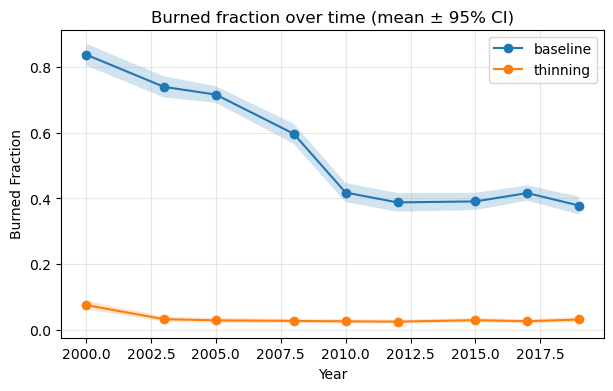

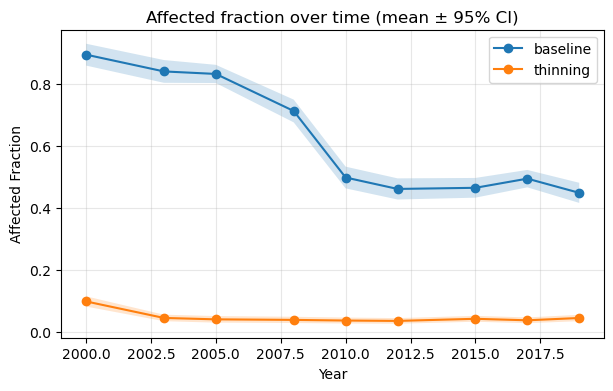

In [12]:
# Burned + affected fractions over time (mean ± 95% CI)
#
# This is the main time-series result:
# - Burned fraction: fraction of cells that burn per run
# - Affected fraction: burned + adjacent-to-burned per run
#
# For each year and scenario (baseline vs thinning), we compute a mean and a normal-approximation 95% CI.

years = list(years_to_analyze)

def mean_ci(arr):
    m, lo, hi = DataCollector.calculate_ci95_mean(np.asarray(arr, float))
    return float(m), float(lo), float(hi)

burn_mean_b, burn_lo_b, burn_hi_b = [], [], []
burn_mean_t, burn_lo_t, burn_hi_t = [], [], []
aff_mean_b, aff_lo_b, aff_hi_b = [], [], []
aff_mean_t, aff_lo_t, aff_hi_t = [], [], []

for y in years:
    burned_b, affected_b, _ = results[(y, "baseline")]
    burned_t, affected_t, _ = results[(y, "thinning")]

    m, lo, hi = mean_ci(burned_b)
    burn_mean_b.append(m); burn_lo_b.append(lo); burn_hi_b.append(hi)

    m, lo, hi = mean_ci(burned_t)
    burn_mean_t.append(m); burn_lo_t.append(lo); burn_hi_t.append(hi)

    m, lo, hi = mean_ci(affected_b)
    aff_mean_b.append(m); aff_lo_b.append(lo); aff_hi_b.append(hi)

    m, lo, hi = mean_ci(affected_t)
    aff_mean_t.append(m); aff_lo_t.append(lo); aff_hi_t.append(hi)

plt.figure(figsize=(7,4))
plt.plot(years, burn_mean_b, marker="o", label="baseline")
plt.fill_between(years, burn_lo_b, burn_hi_b, alpha=0.2)
plt.plot(years, burn_mean_t, marker="o", label="thinning")
plt.fill_between(years, burn_lo_t, burn_hi_t, alpha=0.2)
plt.title("Burned fraction over time (mean ± 95% CI)")
plt.xlabel("Year")
plt.ylabel("Burned Fraction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(years, aff_mean_b, marker="o", label="baseline")
plt.fill_between(years, aff_lo_b, aff_hi_b, alpha=0.2)
plt.plot(years, aff_mean_t, marker="o", label="thinning")
plt.fill_between(years, aff_lo_t, aff_hi_t, alpha=0.2)
plt.title("Affected fraction over time (mean ± 95% CI)")
plt.xlabel("Year")
plt.ylabel("Affected Fraction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Uncertainty Analysis & Sample Size Estimation
#
# Rule: "Analyze the remaining uncertainty... how many more simulation runs wewould need"
#
# We use the standard error relationship: Width ∝ 1/sqrt(N)
# N_new = N_old * (Width_old / Width_target)^2

current_runs = n_runs  # defined in the simulation loop cell
target_width = 0.02    # Aim for a CI width of 2% (±1%)

print(f"Uncertainty Analysis (Current N={current_runs})")

max_width = 0.0
worst_year = None
scenario_widths = []

for y in years_to_analyze:
    # Check baseline (usually has higher variance than thinning)
    burned_b, _, _ = results[(y, "baseline")]
    mean_b, lo_b, hi_b = DataCollector.calculate_ci95_mean(burned_b)
    width_b = hi_b - lo_b
    scenario_widths.append(width_b)
    
    if width_b > max_width:
        max_width = width_b
        worst_year = y

print(f"\nMaximum CI width observed: {max_width:.4f} (Year {worst_year}, Baseline)")
print(f"Average CI width: {np.mean(scenario_widths):.4f}")

# Estimate required N
# Formula: N_target = N_current * (Width_current / Width_target)^2
required_n = int(current_runs * (max_width / target_width)**2)

print(f"\nSample Size Estimation\n")
print(f"Target CI width: {target_width} (i.e., mean ± {target_width/2:.1%})")
print(f"To achieve this precision for the worst-case year, wewould need:")
print(f"Estimated N ≈ {required_n} runs")
print(f"Additional runs needed: {max(0, required_n - current_runs)}")

# Interpretation
if max_width > 0.05:
    status = "WIDE"
    comment = "The intervals are relatively wide (>5%), indicating moderate uncertainty. More runs are recommended for precise point estimates."
elif max_width > 0.01:
    status = "MODERATE"
    comment = "The intervals are moderate (1-5%). The overall trends are clear and statistically significant, but precise risk values have some noise."
else:
    status = "NARROW"
    comment = "The intervals are narrow (<1%), indicating high precision."

print(f"\nInterpretation: {status}")
print(comment)

Uncertainty Analysis (Current N=200)

Maximum CI width observed: 0.0661 (Year 2000, Baseline)
Average CI width: 0.0569

Sample Size Estimation

Target CI width: 0.02 (i.e., mean ± 1.0%)
To achieve this precision for the worst-case year, you would need:
Estimated N ≈ 2181 runs
Additional runs needed: 1981

Interpretation: WIDE
The intervals are relatively wide (>5%), indicating moderate uncertainty. More runs are recommended for precise point estimates.


## Significance Test of Thinning

In [14]:
alpha = 0.05

p_b_adj, rej_b = holm_bonferroni(p_burned, alpha=alpha)
p_a_adj, rej_a = holm_bonferroni(p_affected, alpha=alpha)

print("\nMultiple comparisons correction (Holm–Bonferroni, per-metric across years)\n")
for i, y in enumerate(years_to_analyze):
    print(
        f"Year {y}: "
        f"Delta burned={delta_burned[i]:.4f}, p_adj_burned={p_b_adj[i]:.4g}, reject={bool(rej_b[i])} | "
        f"Delta affected={delta_affected[i]:.4f}, p_adj_affected={p_a_adj[i]:.4g}, reject={bool(rej_a[i])}"
    )


Multiple comparisons correction (Holm–Bonferroni, per-metric across years)

Year 2000: Delta burned=0.7627, p_adj_burned=0.0018, reject=True | Delta affected=0.7951, p_adj_affected=0.0018, reject=True
Year 2003: Delta burned=0.7073, p_adj_burned=0.0018, reject=True | Delta affected=0.7942, p_adj_affected=0.0018, reject=True
Year 2005: Delta burned=0.6874, p_adj_burned=0.0018, reject=True | Delta affected=0.7907, p_adj_affected=0.0018, reject=True
Year 2008: Delta burned=0.5698, p_adj_burned=0.0018, reject=True | Delta affected=0.6730, p_adj_affected=0.0018, reject=True
Year 2010: Delta burned=0.3921, p_adj_burned=0.0018, reject=True | Delta affected=0.4608, p_adj_affected=0.0018, reject=True
Year 2012: Delta burned=0.3630, p_adj_burned=0.0018, reject=True | Delta affected=0.4252, p_adj_affected=0.0018, reject=True
Year 2015: Delta burned=0.3616, p_adj_burned=0.0018, reject=True | Delta affected=0.4220, p_adj_affected=0.0018, reject=True
Year 2017: Delta burned=0.3903, p_adj_burned=0.0

# Theoretical vs empirical comparison (density scaling sweeps)
This section connects the simulation to percolation/connectivity intuition.

Idea:
- Scale a fixed year's density map by a factor c in [0, 1] (uniform thinning).
- Estimate the expected burned fraction as a function of c.
- A nonlinear/transition-like curve supports the connectivity intuition.

Minimal robustness setup:
- Run the sweep for 3 representative years:
  * 2000 (baseline)
  * 2012 (gain breakpoint in our simplified time series)
  * 2019 (end of available lossyear range)
  
Note: This is not part of the thinning significance test; it's a qualitative/theory check.

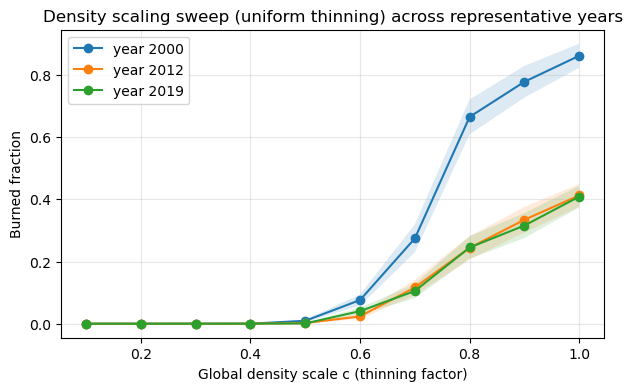

In [15]:
# Density scaling sweep (multi-year overlay)

base_years_for_sweep = (2000, 2012, 2019)

# Keep modest so runtime stays reasonable.
sweep_runs = 100
scales = np.linspace(0.1, 1.0, 10)


def run_density_scaling_sweep(base_year: int, scales, sweep_runs: int):
    """Run a uniform thinning sweep on a fixed base-year landscape.

    Returns:
      means: mean burned fraction at each scale
      ci_lo/ci_hi: 95% CI bounds for the mean at each scale
    """
    base_density = density_for_year(base_year)
    base_forest = Forest(base_density)

    means, ci_lo, ci_hi = [], [], []

    for c in scales:
        forest_c = base_forest.apply_thinning(float(c))
        mc_c = MonteCarlo(
            forest=forest_c,
            params=params,
            n_runs=sweep_runs,
            rng=np.random.default_rng(base_year * 10_000 + int(1_000 * c)),
        )

        report_c = mc_c.run()
        burned_c, _ = report_c.convert_to_arrays()
        mean_c, lo_c, hi_c = DataCollector.calculate_ci95_mean(burned_c)

        means.append(float(mean_c))
        ci_lo.append(float(lo_c))
        ci_hi.append(float(hi_c))

    return means, ci_lo, ci_hi


sweep_results = {y: run_density_scaling_sweep(y, scales=scales, sweep_runs=sweep_runs) for y in base_years_for_sweep}

plt.figure(figsize=(7, 4))
for y in base_years_for_sweep:
    means, lo, hi = sweep_results[y]
    plt.plot(scales, means, marker="o", label=f"year {y}")
    plt.fill_between(scales, lo, hi, alpha=0.15)

plt.title("Density scaling sweep (uniform thinning) across representative years")
plt.xlabel("Global density scale c (thinning factor)")
plt.ylabel("Burned fraction")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Formatting Grid Displays

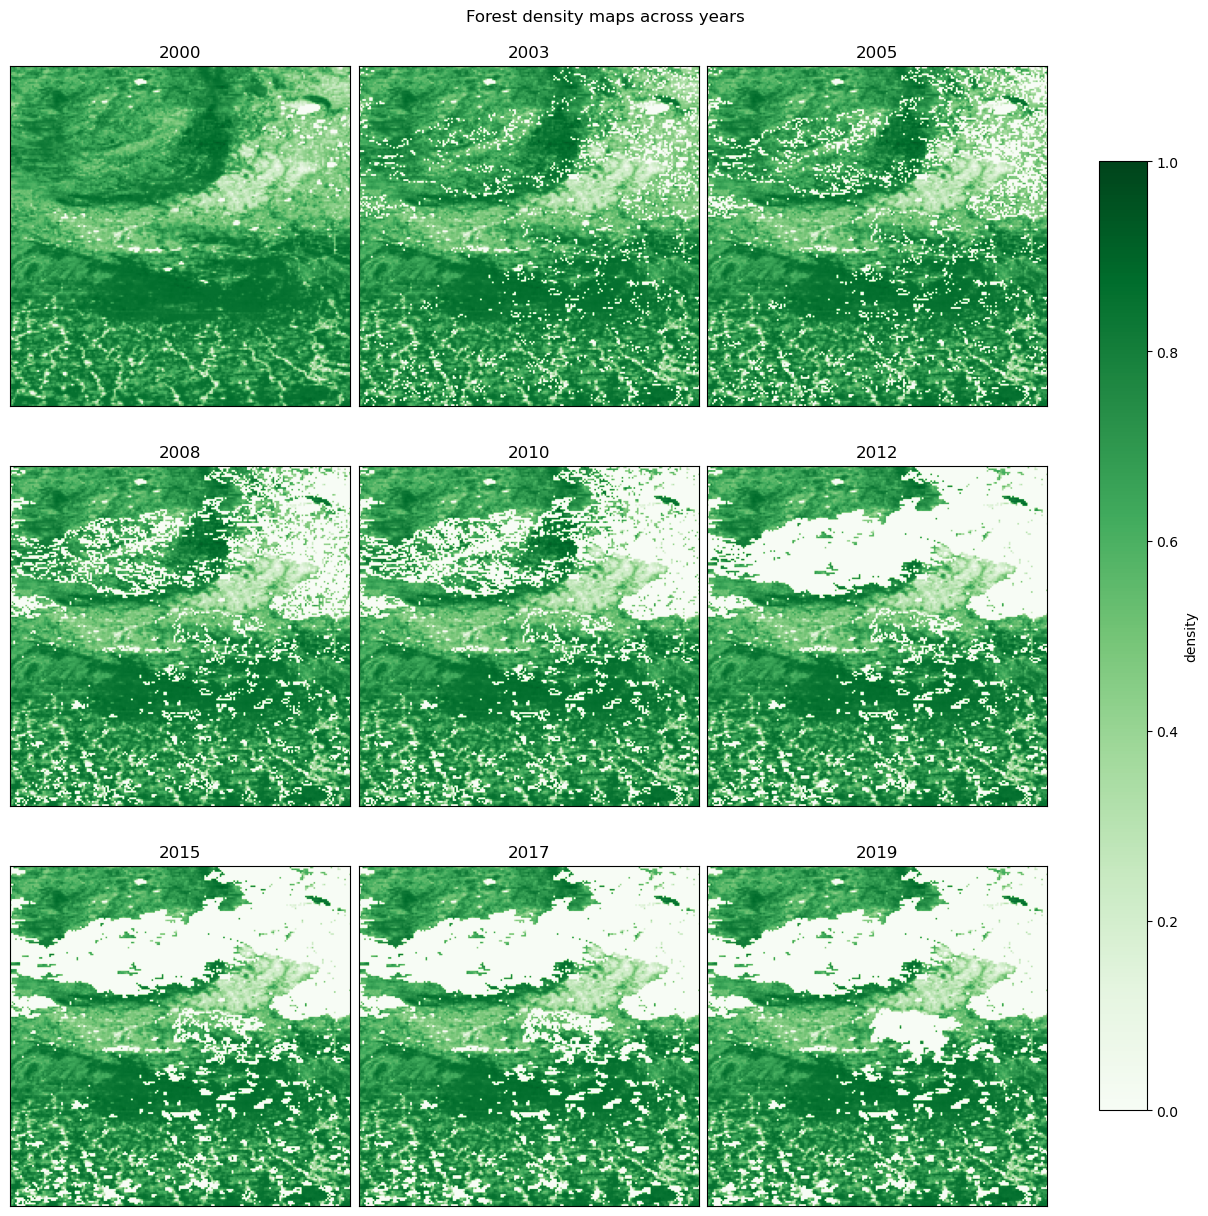

In [ ]:
# Display all density maps together (row or grid)
# Uses `years_to_plot` + `density_for_year` defined above.

import math
import numpy as np
import matplotlib.pyplot as plt

layout = "grid"  # "grid" or "row"

maps = [density_for_year(y) for y in years_to_plot]

# Keep colors comparable across years
vmin, vmax = 0.0, 1.0

n = len(years_to_plot)
if layout == "row":
    ncols = n
else:
    ncols = 3  # change to 4 if wewant a wider grid
nrows = int(math.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 4 * nrows),
    constrained_layout=True,
)

axes = np.atleast_1d(axes).ravel()

im = None
for i, (y, d) in enumerate(zip(years_to_plot, maps)):
    ax = axes[i]
    im = ax.imshow(d, cmap="Greens", vmin=vmin, vmax=vmax)
    ax.set_title(f"{y}", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

cbar = fig.colorbar(im, ax=axes[:n], shrink=0.8)
cbar.set_label("density", fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.suptitle("Forest density maps across years", y=1.02, fontsize=20)
plt.show()

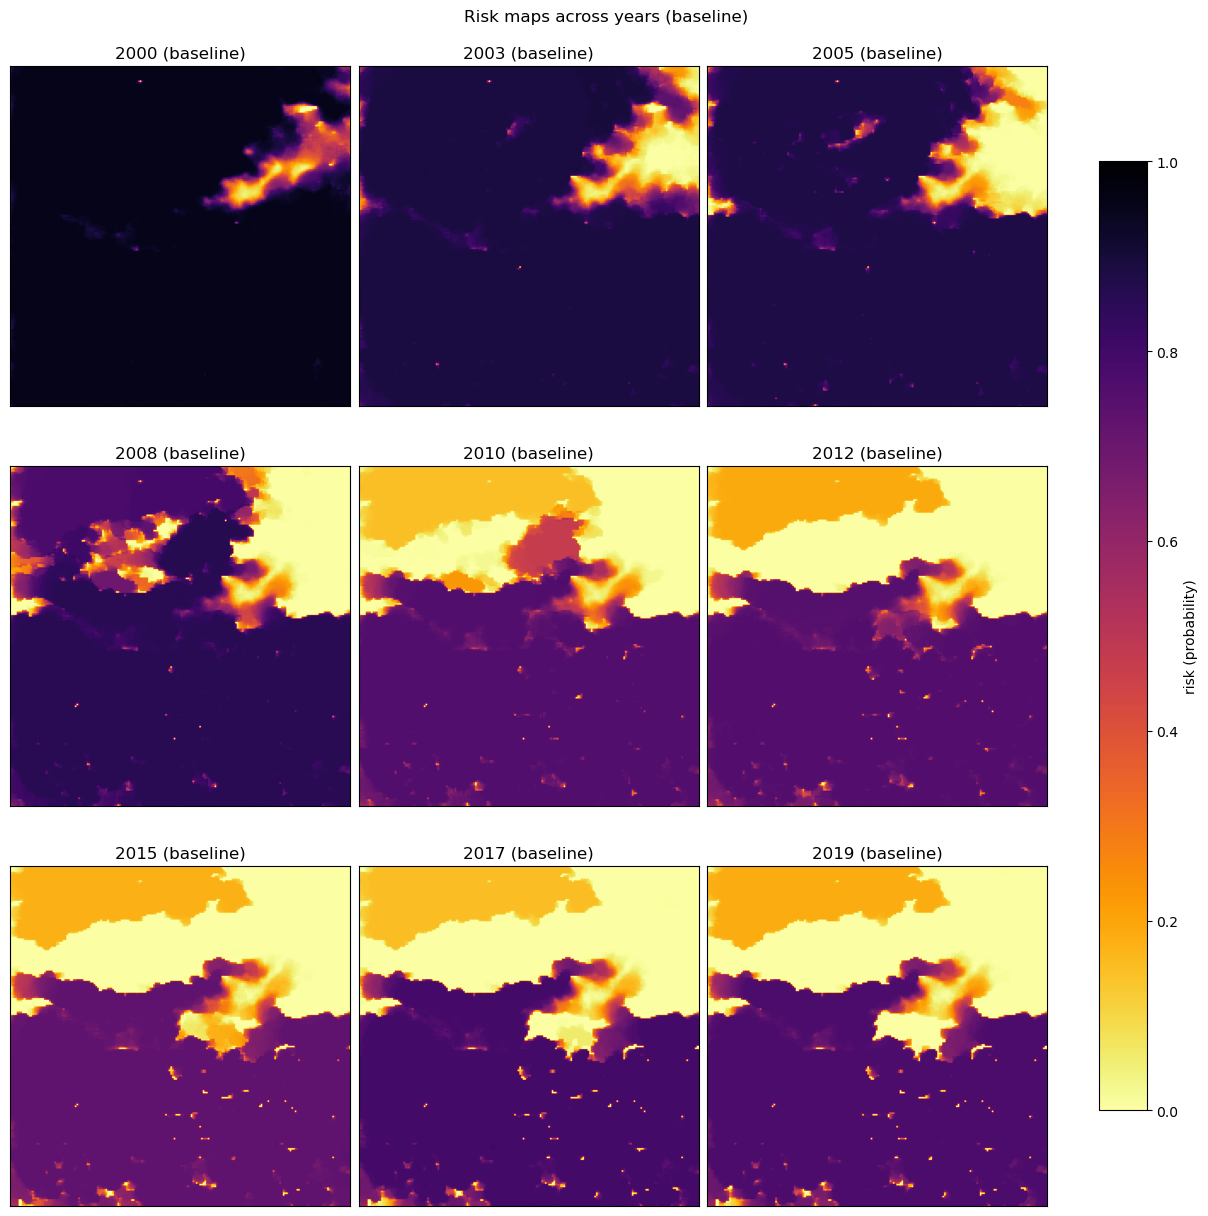

In [ ]:
# Display all risk maps together (baseline and thinning) in a grid
# This is fast: it only plots arrays already stored in `results`.

import math
import numpy as np
import matplotlib.pyplot as plt

scenario = "baseline"  # "baseline" or "thinning"
layout = "grid"        # "grid" or "row"

years = list(years_to_analyze)
risk_maps = [results[(y, scenario)][2] for y in years]

vmin, vmax = 0.0, 1.0
cmap = "inferno_r"  # higher risk darker, consistent with your single plots

n = len(years)
if layout == "row":
    ncols = n
else:
    ncols = 3  # try 4 if wewant it wider
nrows = int(math.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 4 * nrows),
    constrained_layout=True,
)
axes = np.atleast_1d(axes).ravel()

im = None
for i, (y, r) in enumerate(zip(years, risk_maps)):
    ax = axes[i]
    im = ax.imshow(r, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f"{y} ({scenario})", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

cbar = fig.colorbar(im, ax=axes[:n], shrink=0.8)
cbar.set_label("risk (probability)", fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.suptitle(f"Risk maps across years ({scenario})", y=1.02, fontsize=20)
plt.show()

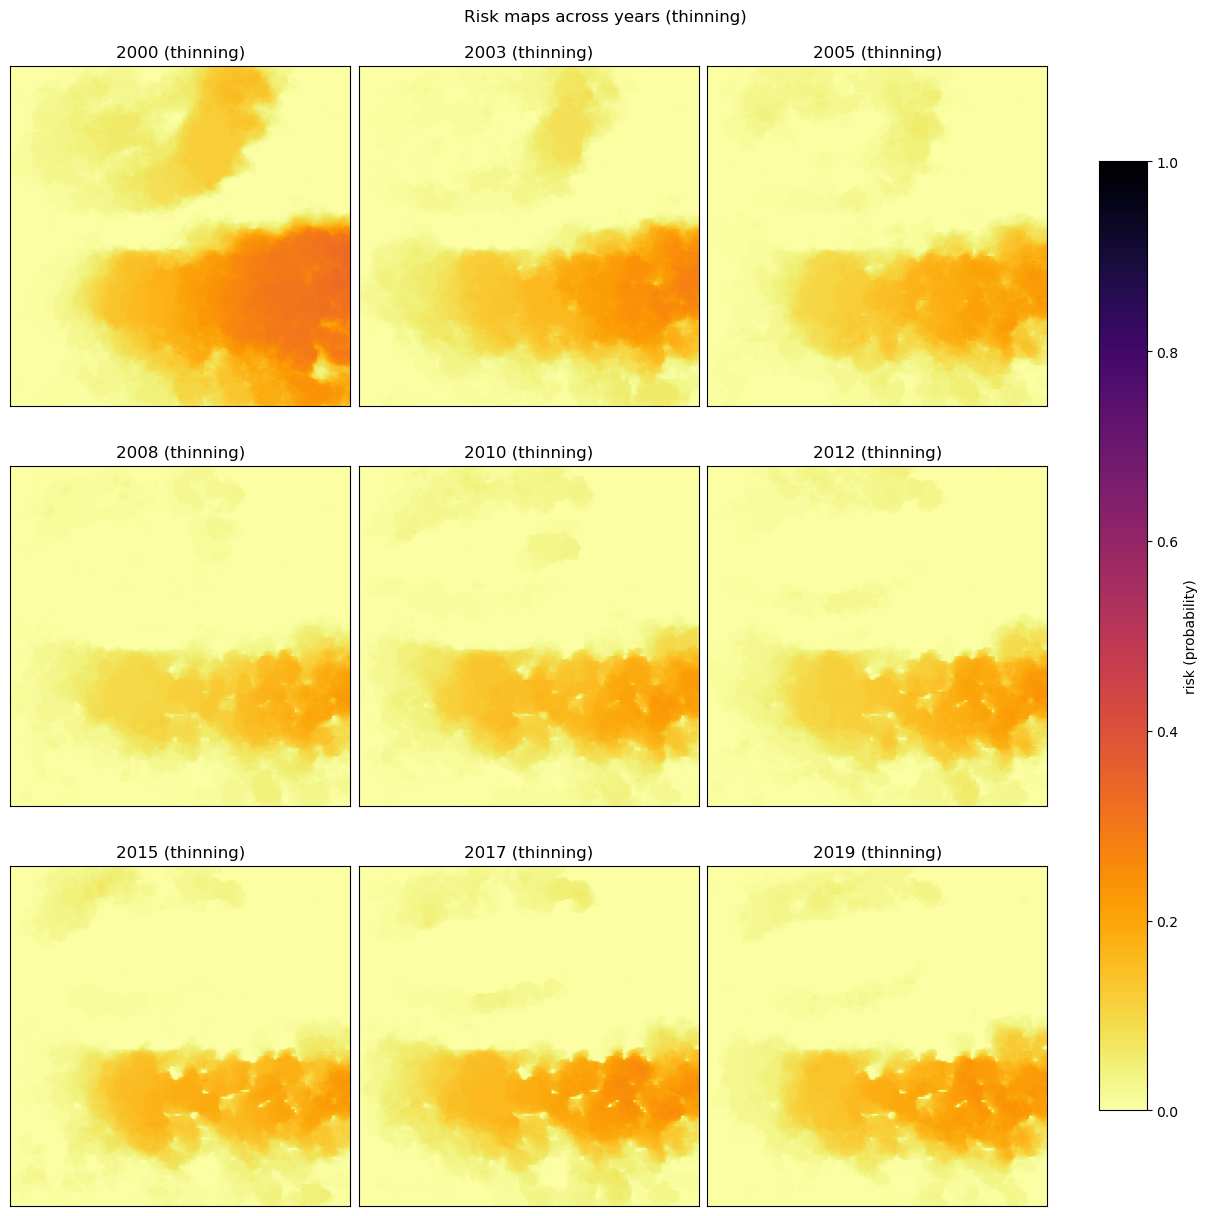

In [ ]:
# Display all risk maps together (baseline and thinning) in a grid
# This is fast: it only plots arrays already stored in `results`.

import math
import numpy as np
import matplotlib.pyplot as plt

scenario = "thinning"  # "baseline" or "thinning"
layout = "grid"        # "grid" or "row"

years = list(years_to_analyze)
risk_maps = [results[(y, scenario)][2] for y in years]

vmin, vmax = 0.0, 1.0
cmap = "inferno_r"  # higher risk darker, consistent with your single plots

n = len(years)
if layout == "row":
    ncols = n
else:
    ncols = 3  # try 4 if wewant it wider
nrows = int(math.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 4 * nrows),
    constrained_layout=True,
)
axes = np.atleast_1d(axes).ravel()

im = None
for i, (y, r) in enumerate(zip(years, risk_maps)):
    ax = axes[i]
    im = ax.imshow(r, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f"{y} ({scenario})", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

cbar = fig.colorbar(im, ax=axes[:n], shrink=0.8)
cbar.set_label("risk (probability)", fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.suptitle(f"Risk maps across years ({scenario})", y=1.02, fontsize=20)
plt.show()

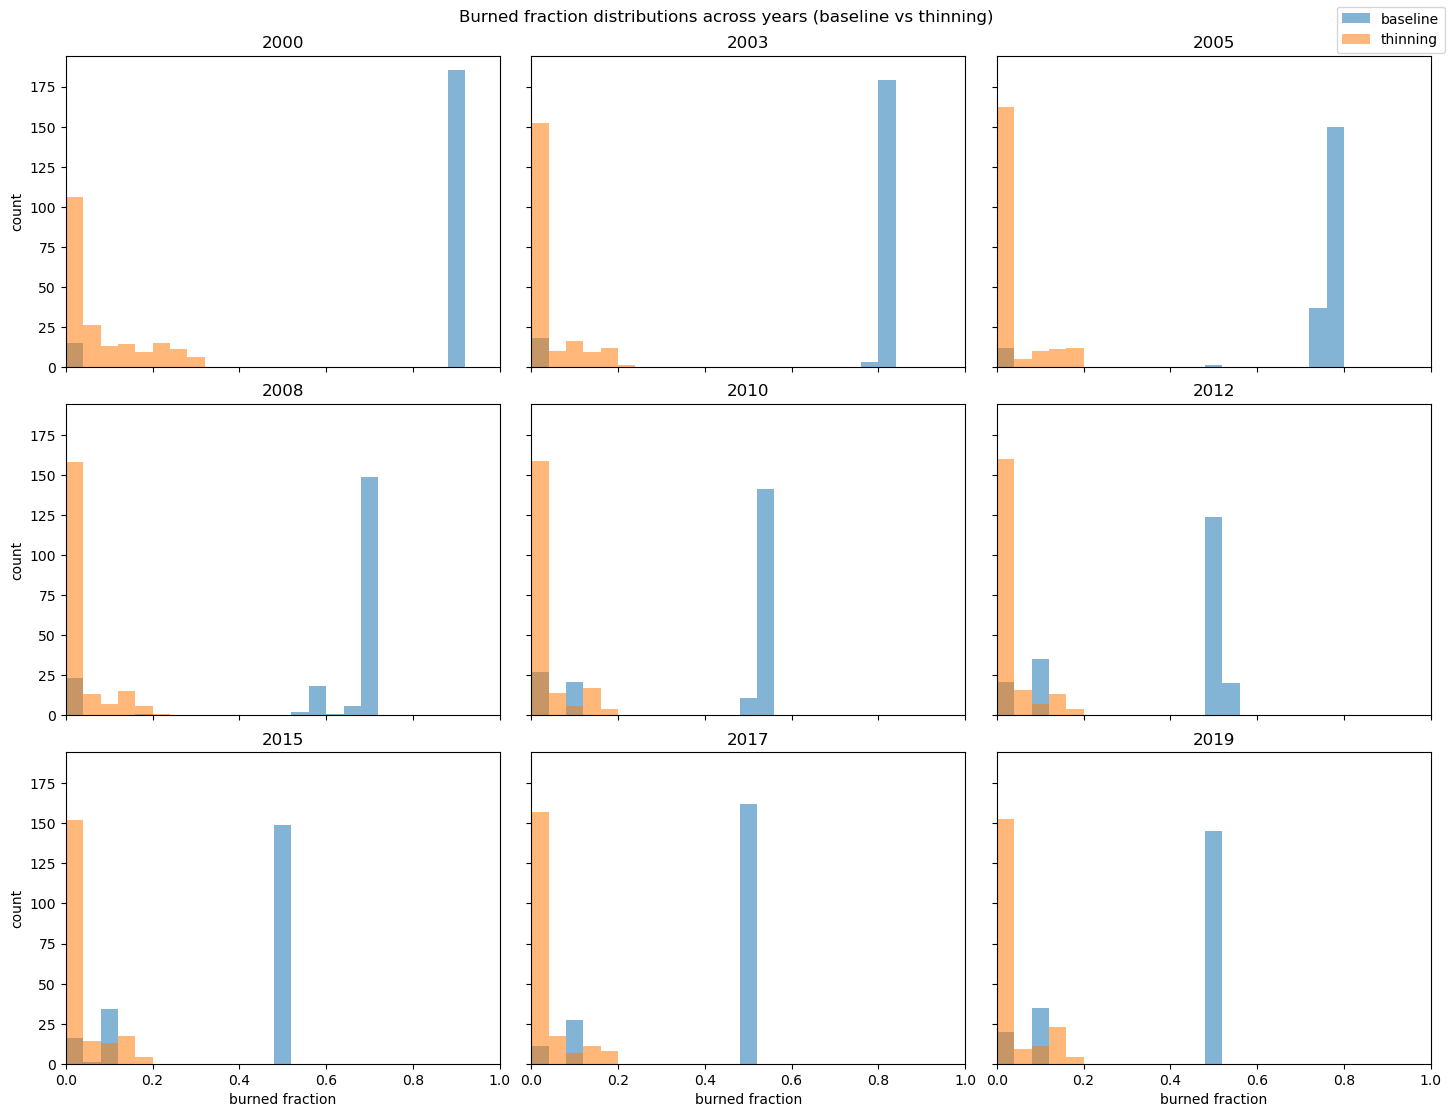

In [ ]:
# Burned fraction histograms together (baseline vs thinning) across years
# Fast: uses already-stored arrays in `results`.

import numpy as np
import matplotlib.pyplot as plt

years = list(years_to_analyze)

bins = 25
xlim = (0.0, 1.0)   # keep consistent across years
sharey = True       # makes counts comparable across subplots

ncols = 3  # change to 4 if wewant a wider grid
nrows = int(np.ceil(len(years) / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4.8 * ncols, 3.6 * nrows),
    constrained_layout=True,
    sharex=True,
    sharey=sharey,
)
axes = np.atleast_1d(axes).ravel()

for i, y in enumerate(years):
    burned_b = results[(y, "baseline")][0]
    burned_t = results[(y, "thinning")][0]

    ax = axes[i]
    ax.hist(burned_b, bins=bins, range=xlim, alpha=0.55, label="baseline")
    ax.hist(burned_t, bins=bins, range=xlim, alpha=0.55, label="thinning")
    ax.set_title(f"{y}", fontsize=16)
    ax.set_xlim(*xlim)
    ax.tick_params(axis='both', which='major', labelsize=12)

    if i % ncols == 0:
        ax.set_ylabel("count", fontsize=14)
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel("burned fraction", fontsize=14)

# Turn off unused slots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# One legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=14)
fig.suptitle("Burned fraction distributions across years (baseline vs thinning)", y=1.02, fontsize=20)

plt.show()